In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [7]:
# Load datasets
df_b0006 = pd.read_csv('/kaggle/input/nasa-data-set/NASA_cycle_dataset_B0006.csv')
df_b0005 = pd.read_csv('/kaggle/input/nasa-data-set/NASA_cycle_dataset_B0005.csv')
df_b0007 = pd.read_csv('/kaggle/input/nasa-data-set/NASA_cycle_dataset_B0007.csv')
df_b0018 = pd.read_csv('/kaggle/input/nasa-data-set/NASA_cycle_dataset_B0018.csv')

# Add battery_id column
df_b0006['battery_id'] = 'B0006'
df_b0005['battery_id'] = 'B0005'
df_b0007['battery_id'] = 'B0007'
df_b0018['battery_id'] = 'B0018'

# Combine datasets
df = pd.concat([df_b0005, df_b0007, df_b0006, df_b0018], axis=0, ignore_index=True)

# Drop NaN values
df.dropna(inplace=True)

In [8]:
print(df.columns)


Index(['Unnamed: 0', 'cycle', 'ambient_temperature', 'datetime',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current', 'voltage', 'time', 'capacity', 'battery_id'],
      dtype='object')


Top 10 Features: ['Unnamed: 0', 'cycle', 'battery_id', 'current', 'current_measured', 'time', 'temperature_measured', 'voltage', 'voltage_measured', 'temperature_measured_ema']
Cross-Validation R2 Scores: [0.99989067 0.99989129 0.99988678 0.99988403 0.99988986]
Mean Cross-Validation R2: 0.9999
Cross-Validation RMSE Scores: [0.00199125 0.00199631 0.00202703 0.00205269 0.00200013]
Mean Cross-Validation RMSE: 0.0020
Cross-Validation MAE Scores: [0.00132145 0.00131722 0.00134037 0.00134155 0.00132018]
Mean Cross-Validation MAE: 0.0013
RMSE: 0.0022
MAE: 0.0014
R2 Score: 0.9999


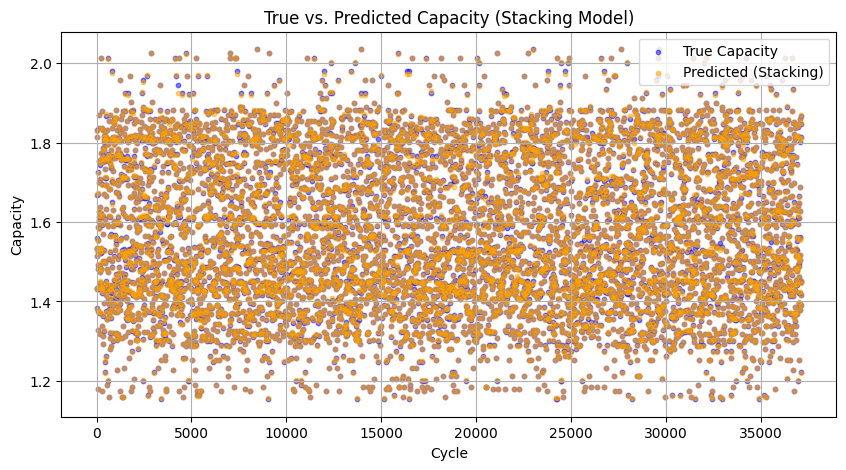

In [10]:
# Encode categorical column
df['battery_id'] = LabelEncoder().fit_transform(df['battery_id'])

# Feature Engineering
window_size = 10  # Increased window size
for col in ['voltage_measured', 'current_measured', 'temperature_measured']:
    df[f'{col}_rolling_mean'] = df[col].rolling(window=window_size, min_periods=1).mean()
    df[f'{col}_rolling_std'] = df[col].rolling(window=window_size, min_periods=1).std()
    df[f'{col}_ema'] = df[col].ewm(span=window_size, adjust=False).mean()

# Differential Features with Rolling Gradient
df['capacity_gradient'] = df['capacity'].rolling(window=window_size).apply(lambda x: np.gradient(x)[-1], raw=True)

# Fill NaN values created by transformations
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Ensure no NaN values remain
assert not df.isnull().values.any(), "Data contains NaN values!"

# Feature selection using RandomForest
rf = RandomForestRegressor(random_state=42)
X = df.drop(columns=['capacity', 'datetime'], errors='ignore')
y = df['capacity']
rf.fit(X, y)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)['Feature'].tolist()
print("Top 10 Features:", top_features)

# Use only the selected top 10 features for training
X = X[top_features]

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train XGBoost base models
xgb_model_1 = XGBRegressor(random_state=42)
xgb_model_2 = XGBRegressor(random_state=42, max_depth=5, learning_rate=0.05, n_estimators=300)

xgb_model_1.fit(X_train, y_train)
xgb_model_2.fit(X_train, y_train)

# Generate meta-features
y_pred_xgb_1 = xgb_model_1.predict(X_test)
y_pred_xgb_2 = xgb_model_2.predict(X_test)

meta_features_train = np.column_stack((xgb_model_1.predict(X_train), xgb_model_2.predict(X_train)))
meta_features_test = np.column_stack((y_pred_xgb_1, y_pred_xgb_2))

# Train Ridge Regression meta-learner
ridge = Ridge()
ridge.fit(meta_features_train, y_train)
y_pred_meta = ridge.predict(meta_features_test)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation R²
cross_val_r2 = cross_val_score(ridge, meta_features_train, y_train, cv=kf, scoring='r2')
print(f"Cross-Validation R2 Scores: {cross_val_r2}")
print(f"Mean Cross-Validation R2: {np.mean(cross_val_r2):.4f}")

# Cross-validation RMSE (neg_mean_squared_error → take absolute and sqrt)
cross_val_rmse = np.sqrt(-cross_val_score(ridge, meta_features_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
print(f"Cross-Validation RMSE Scores: {cross_val_rmse}")
print(f"Mean Cross-Validation RMSE: {np.mean(cross_val_rmse):.4f}")

# Cross-validation MAE (neg_mean_absolute_error → take absolute value)
cross_val_mae = -cross_val_score(ridge, meta_features_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE Scores: {cross_val_mae}")
print(f"Mean Cross-Validation MAE: {np.mean(cross_val_mae):.4f}")

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_meta))
mae = mean_absolute_error(y_test, y_pred_meta)
r2 = r2_score(y_test, y_pred_meta)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot True vs. Predicted Capacity
plt.figure(figsize=(10, 5))
plt.scatter(range(0, len(y_test), 5), y_test[::5], label="True Capacity", color='blue', alpha=0.5, s=10)
plt.scatter(range(0, len(y_pred_meta), 5), y_pred_meta[::5], label="Predicted (Stacking)", color='orange', alpha=0.5, s=10)
plt.xlabel("Cycle")
plt.ylabel("Capacity")
plt.title("True vs. Predicted Capacity (Stacking Model)")
plt.legend()
plt.grid(True)
plt.show()
